# Лабораторная работа 4
## Кривые обучения и регуляризация

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Импортируем датасет ```BostonHousing``` и выделяем признаки и метки из него

In [17]:
housing = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv', sep=',')
housing.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [18]:
X = housing.drop('medv', axis=1)
y = housing['medv']

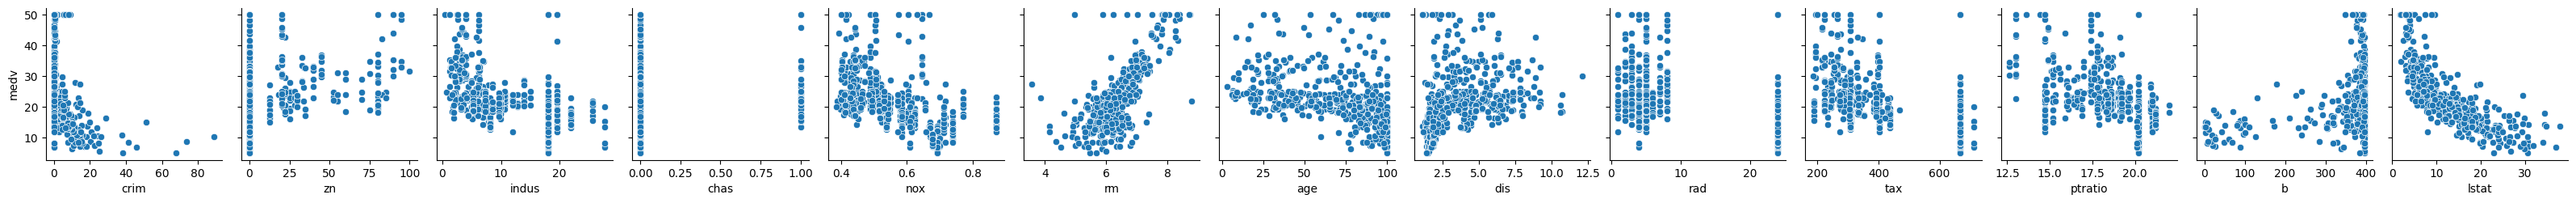

In [19]:
sns.pairplot(housing, x_vars=X.columns, y_vars=y.name)

### Часть 1

В качестве регрессоров возьмем ```Полиномиальную Регрессию``` и ```Случайный Лес```

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

In [21]:
poly_model = make_pipeline(PolynomialFeatures(2), LinearRegression())
rf_model = RandomForestRegressor()

Построим кривые обучения

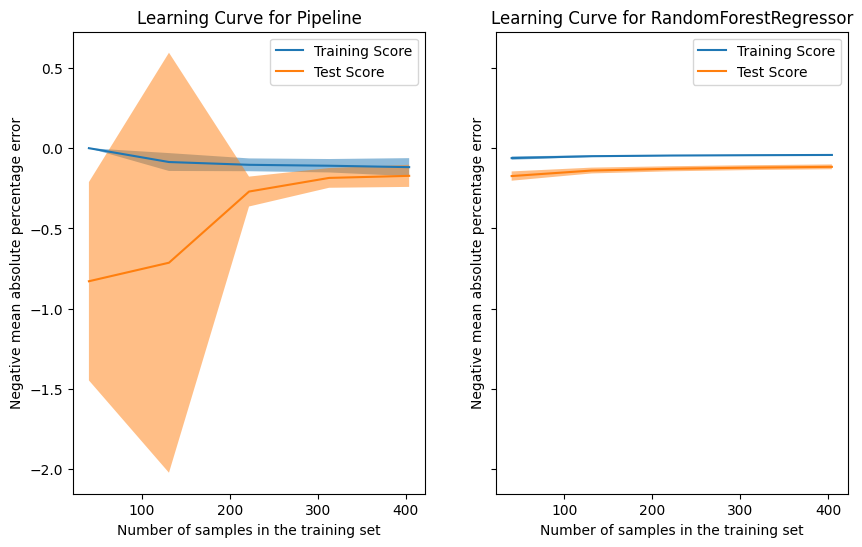

In [47]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "scoring": "neg_mean_absolute_percentage_error",
}

for ax_idx, estimator in enumerate([poly_model, rf_model]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

Как видим обе модели получились очень точными: среднее отклонение на малом наборе данных отклоняется от фактических в случае ```Полиномиальной Регрессии``` на ```0.8%``` и в случае ```Случайного Леса``` (без подбора гиперпараметров) на ```0.2%```, на большом наборе данных модели приблизились к ошибке в ```0.2%``` и ```0.1%``` соотвественно. Вывод - ```Случайный Лес``` оказался 
более подходящим решением для данной задачи.

Оценим недо- и пере- обученность моделей:
1) ```Полиномиальная регрессия``` имеет некоторые черты переобученности на количестве образцов (```samples```) менее 200-ти, так как ошибка на тренировочном наборе околонулевая, а на тестовом до ```0.8%```. Однако же данную модель переобученной назвать нельзя, так как она имеет очень высокую точность;
2) ```Случайный Лес``` же не имеет признаков переобученности или недообученности, потому что он показал ошибку равную ```0.2%``` даже на малом наборе данных.

Возьмём за целевое значение нашей метрики ```MAPE``` величину равную ```0.5%``` и отобразим ее на полученных кривых.

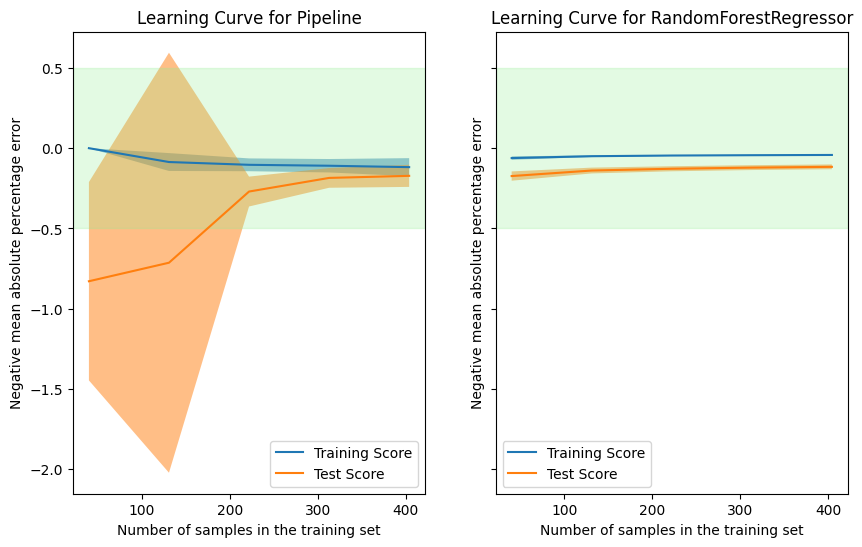

In [48]:
y0 = -0.5
y1 = 0.5

for ax_idx in range(len(ax)):
    ax[ax_idx].axhspan(y0, y1, color='lightgreen', alpha=0.25)
    ax[ax_idx].figure.canvas.draw()
display(fig)

### Часть 2

Последовательно выполним обучение моделей ```Линейной регрессии```, ```Гребневой регуляризации``` (```Ridge```)  и ```Lasso регуляризации```.

_Теория:_ эти 3 модели одинаковы по сути, но отличаются только функцией ошибок, так как ```Лассо``` и ```Ридж``` регуляризации являются модификациями обычной ```Линейной регрессии``` - модели штрафуются за большие веса гиперплоскости. Это уменьшает дисперсию модели на тестовых данных, позволяет нам уменьшить веса бесполезных признаков, которые бы только вносили шум в наше предсказание.

$ L = \sum_{i}(y_i - f(x_i))^2 $ - функция ошибок ```Линейной регрессии```

$ L_{Lasso} = \sum_{i}(y_i - f(x_i))^2 + \lambda |w| $ - функция ошибок ```Лассо регуляризации```

$ L_{Ridge} = \sum_{i}(y_i - f(x_i))^2  + \lambda w^2 $ - функция ошибок ```Гребневой (Ridge) регуляризации```

Где $ \lambda $ - гиперпараметр для регуляризации штрафа за веса.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

linear_model = LinearRegression().fit(X_train, y_train)
lasso_model = Lasso().fit(X_train, y_train)
ridge_model = Ridge().fit(X_train, y_train)

Сравним модели, используя несколько метрик

In [58]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
for model in (linear_model, lasso_model, ridge_model):
    print(type(model).__name__)
    print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(y_test, model.predict(X_test))}')
    print(f'mean_squared_error: {mean_squared_error(y_test, model.predict(X_test))}')
    print(f'r2_score: {r2_score(y_test, model.predict(X_test))}\n')

LinearRegression
mean_absolute_percentage_error: 0.1778099125732869
mean_squared_error: 26.558581842040887
r2_score: 0.6705795412578767

Lasso
mean_absolute_percentage_error: 0.1790155754480345
mean_squared_error: 31.40533015845443
r2_score: 0.6104626998054012

Ridge
mean_absolute_percentage_error: 0.17775956818462169
mean_squared_error: 27.042676333702083
r2_score: 0.6645750553833661



Видим, что модели получились очень точными и ошибки в трех моделях не имеют сильного отличия друг от друга. ```MAPE``` практически одинаковые в 
```Линейной регрессии``` и ```Ридж```, чуть хуже в ```Лассо```. ```MSE``` лучше всего в ```ЛР```, не сильно отличается в ```Ридж``` и заметно хуже в ```Лассо```.
И ```R2``` или же ```коэффициент детерминации``` лучше всего в ```Лассо``` и примерно одинаковые в двух остальных.
 
Можно сделать вывод, что модели одинаковы по точности.

Оценим значения коэффициентов регрессий

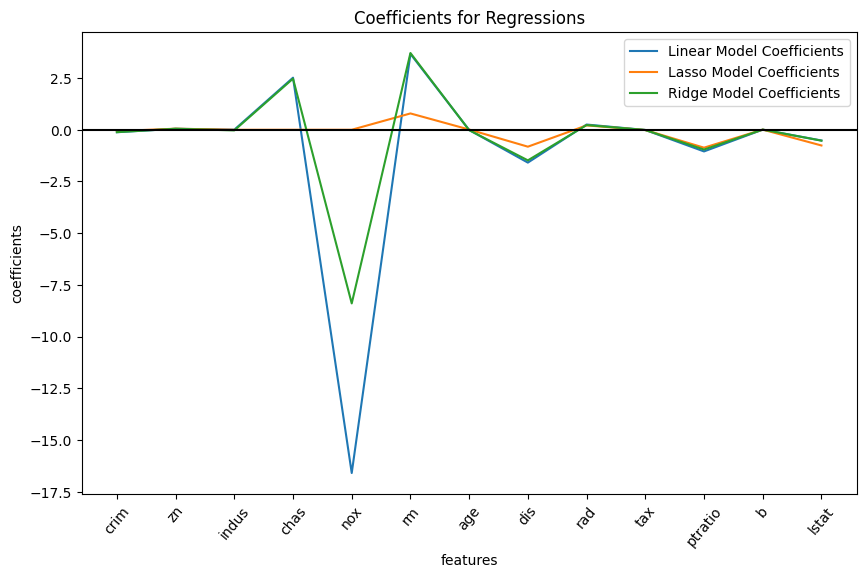

In [65]:
feature_names = X.columns

linear_model_coef = linear_model.coef_
lasso_model_coef = lasso_model.coef_
ridge_model_coef = ridge_model.coef_

plt.figure(figsize=(10, 6))

plt.plot(range(len(linear_model_coef)), linear_model_coef, label='Linear Model Coefficients')
plt.plot(range(len(lasso_model_coef)), lasso_model_coef, label='Lasso Model Coefficients')
plt.plot(range(len(ridge_model_coef)), ridge_model_coef, label='Ridge Model Coefficients')

plt.axhline(0, color='black', linestyle = 'solid')
plt.xticks(range(len(feature_names)), feature_names, rotation = 50)
plt.title("Coefficients for Regressions")
plt.ylabel("coefficients")
plt.xlabel("features")

plt.legend()

Несмотря на то, что модели оказались равными по точности, их коэффициенты сильно разнятся:

```Lasso регуляризация``` гораздо сильнее снижает вляние признаков, чем другие две модели, и имеет относительно маленькие коэффициенты. Что особенно интересно - признак ```nox``` - самый значительный для моделей ```ЛР``` и ```Ридж```, но является __нулевым__ для ```Lasso регуляризации```.

```Ridge регуляризация``` очень сильно сходится с ```ЛР``` и совпадает с ней всюду за исключением признака ```nox```, значение в этом признаке примерно вдвое меньше, из чего можно сделать вывод, что ```Ridge регуляризация``` "сглаживает" только сильно большие признаки в отличие от ```Лассо```.

```Линейная регрессия``` несмотря на то, что не имеет свойства штрафоваться за свои веса, имеет нулевые значения весов в 7 признаках: ```[crim, zn, indus, age, tax, b]```, что говорит, что незначительные признаки не смогли оказать влияния на данную модель (а это является одной из задач штрафования двух других моделей).

### Часть 3 - ElasticNet

Реализуем ```ElasticNet``` модель и сравним ее с моделями из ```Части 2```

_Теория:_ В то время как ```Lasso``` и ```Ridge``` регуляризации являются модификациями ```Линейной регрессии```, ```ElasticNet``` является модификацией ```Lasso``` и ```Ridge``` регуляризаций, являясь их средним. Отличие заключается в функции потерь:

$ L_{ElasticNet} = \sum_{i}(y_i - f(x_i))^2 + \lambda \cdot l1_{ratio} \cdot |w| + \lambda \cdot (1 - l1_{ratio}) \cdot w^2 $ - функция ошибок ```ElasticNet```

Где $ \lambda $ - гиперпараметр для регуляризации штрафа за веса, а $ l1_{ratio} $ - гиперпараметр смешивания ```Lasso``` и ```Ridge``` регуляризаций. Чем больше $ \lambda $, тем сильнее ```ElasticNet``` будет выражаться как ```Lasso``` и слабее как  ```Ridge```, и соотвественно при обратном.

In [67]:
from sklearn.linear_model import ElasticNet

elasticnet_model = ElasticNet().fit(X_train, y_train)
print('ElasticNet')
print(f'mean_absolute_percentage_error: {mean_absolute_percentage_error(y_test, elasticnet_model.predict(X_test))}')
print(f'mean_squared_error: {mean_squared_error(y_test, elasticnet_model.predict(X_test))}')
print(f'r2_score: {r2_score(y_test, elasticnet_model.predict(X_test))}\n')

ElasticNet
mean_absolute_percentage_error: 0.17845233118411555
mean_squared_error: 30.929262074111648
r2_score: 0.6163676298076665



Можем заметить, что при стандартных гиперпараметрах ($ \lambda = 1.0 $ и $ l1_{ratio} = 0.5 $) ```MAPE``` примерно совпадает с  ```ЛР```, ```MSE``` c ```Lasso``` и  ```коэффициент детерминации``` c ```Lasso```. 

Добавим к графику значимости коэффициентов график значимости коэффициентов ```ElasticNet```.

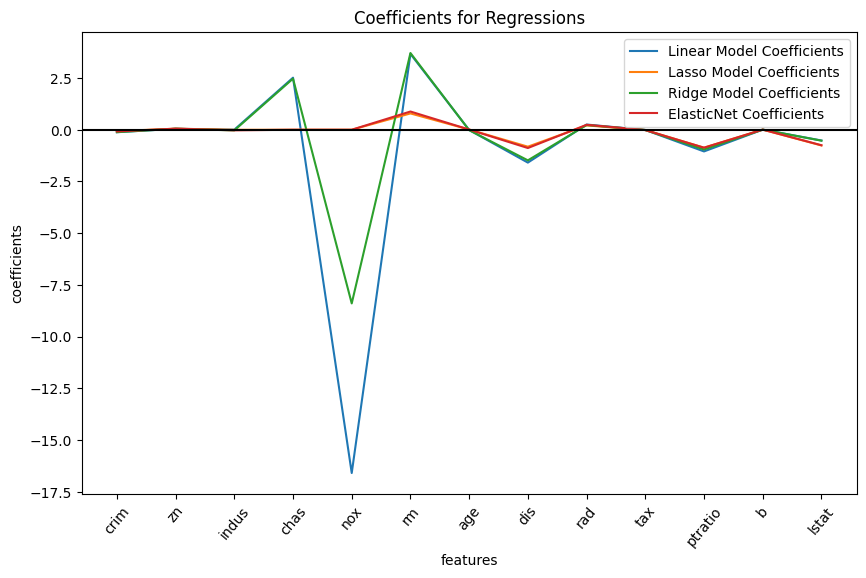

In [70]:
elasticnet_model_coef = elasticnet_model.coef_

plt.figure(figsize=(10, 6))

plt.plot(range(len(linear_model_coef)), linear_model_coef, label='Linear Model Coefficients')
plt.plot(range(len(lasso_model_coef)), lasso_model_coef, label='Lasso Model Coefficients')
plt.plot(range(len(ridge_model_coef)), ridge_model_coef, label='Ridge Model Coefficients')
plt.plot(range(len(elasticnet_model_coef)), elasticnet_model_coef, label='ElasticNet Coefficients')

plt.axhline(0, color='black', linestyle = 'solid')
plt.xticks(range(len(feature_names)), feature_names, rotation = 50)
plt.title("Coefficients for Regressions")
plt.ylabel("coefficients")
plt.xlabel("features")

plt.legend()

Наглядно получаем, что ```ElasticNet``` с $ l1_{ratio} = 0.5 $ то есть являясь серединой между  ```Ridge``` и ```Lasso``` почти полностью совпадает с ```Lasso```, из чего можно сделать вывод, что данная регрессия является преобладающей в ```ElasticNet```.